# Technical Notebook
### Author: Peter Haferl

### Project Introduction:

#### Problem: 
   * During a regular-season night in the National Hockey League (NHL), the number of games occuring can range from 1 to 15 (31 Teams). On nights with many games coinciding it is difficult for the viewer to determine which game  is most likely to be a "good" hockey game. Often times, games with the best teams lead to defensively-focused, controlled, low-scorring affairs while other match-ups can be offensively-focused, loose, and high-scoring. However, this isn't the case all the time and merely guesses which game will display high-quality hockey are often wrong. __Which game should a fan watch on a given night?__
    
#### Goal:
   * Build a classification model to rank the probabilities that NHL regular-season games on a given night will be a 'good' game based on the participating teams' recent performance. Provide NHL fans (users) the with nightly rankings to guide viewing. 
    
#### Methodology:
   * The first step to solving this problem is to define what a 'good' hockey game is. I have my own opinions about what I like to watch in a hockey game, but the goal is to build a general model that all NHL fans can use. The step is an unsupervised learning problem and observation (NHL regular season game) labels will be sourced from the online forum, [Reddit](https://www.reddit.com). The website contains different 'subreddits' (sub-forums) correspoding to many topics, including [r/hockey](https://www.reddit.com/r/hockey) with 889k members. Within this subreddit, after every NHL game, a post titled 'Post Game Thread' is generated which lists the game information and statistics. Users, often with flair (a symbol displaying a team's logo next to the username, denoting fanhood), publish comments in a comment thread under the post discussing the game that just occured. To define what a 'good' hockey game is, the comments will be scraped from the Post Game Threads and treated as viewer-reviews of the respective NHL game. Using natural language processing (NLP) the reviews will undergo sentiment analysis and assigned a sentiment polarity score indicating the positive or negative nature of the comment. The scores will then be aggregated among all comments in a Post Game Thread and each game will be assigned an overall sentiment polarity score, denoting viewers' reaction to the game. __What game qualities lead to positive/negative sentiment polarity scores?__
   
   * The second step is to predict whether upcoming games will obtain high sentiment polarity scores, a proxy for game-quality, based on each teams' recent performance. __Can a model be built to predict game quality (positive sentiment polarity scores)?__

# Package Import

In [1]:
from clean_data import get_clean_data, extract_comment_data
from nltk.sentiment import vader
from sentiment_analysis import analyze_comments, analyze_threads, get_sample_comment
import data_viz
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns



import clean_data

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
%load_ext autoreload

%autoreload 2

# Labelling Data - What makes a good hockey game?

## Import Data

* Import data scraped by scrape_reddit_posts.total_scrape():
       1. reddit_2017_2018 -> output of scrape_reddit_posts.total_scape('2017-10-04', '2018-04-08')
       2. reddit_2018_2019 -> output of scrape_reddit_posts.total_scape('2018-10-03', '2019-04-06')
* Dates were chosen to encapsulate each seasons' regular season games, exluding preseason and playoff games.


* Only recent data, last two seasons, was used in order to prevent longer term effects (e.g. rule changes) from being present in the data. Additionally, the Vegas Golden Knights (VGK) joined the NHL beginning the 2017-2018 Season 

In [4]:
reddit_2017_2018 = pd.read_pickle('./data/reddit_2017_2018')
reddit_2018_2019 = pd.read_pickle('./data/reddit_2018_2019')

reddit = pd.concat([reddit_2017_2018, reddit_2018_2019])

## Clean Data


* Clean data using clean_data.get_clean_data(). Detail of the cleaning procedure can be found in clean_data.py


* hockey_ref_stats is set to True in order to use game statistics scraped from hockey-reference.com instead of statistics parsed from redddit post text. It was found that the hockey-reference.com statistics were more reliable and contained less missing/erroneous values

In [5]:
total_data = get_clean_data(reddit, '2017-10-04', '2019-04-06', hockey_ref_stats=True)

* The clean data contains 2398 entries, each corresponding to a unique hockey game and its corresponding post-game reddit thread. There are a total of 46 features, including information scraped from reddit and corresponding game and team-specific statistics scraped from hockey-refereence.com.


* __Features__:
    * comments (list of strings) 
        * list of comment strings in the reddit thread about a given game
    * author_flair (list of strings) 
        * list of flair for each comment author (same length as comments)
    * date (datetime) 
        * the date of the game
    * away/home_team (string) 
        * 3-letter abbreviation for respective team
    * num-fights (continuous, numeric) 
        * number of fights that occured in the game 
    * num_comments (continuous, numeric) 
        * number of comments in post-game thread
    * comeback? (binary) 
        * Did a team come from behind to win the game?
    * clean_comments (list of strings) 
        * comments cleaned with clean_text.reduce_noise()
    * attendance (continuous, numeric)
        * attendance of the game
    * len_game (continuous, numeric)
        * number of minutes the game lasted (overall, including commercial breaks)
    * home/away_goals (continuous, numeric)
        * number of goals respective team scored
    * win/loss (binary)
        * Did the home team win?
    * ot/so (discrete, numeric)
        * number of extra time sessions needed (1 = OT, 2 = SO)
    * home/away_sog (continuous, numeric)
        * numeber of shots on goal (saved shots + goals) for respective team
    * home/away_pim (continuous, numeric)
        * penalty in minutes (PIM) for respective team
    * home/away_pp_goal (continuous, numeric)
        * powerplay (pp) goals scored by respective
    * home/away_pp_oppurtunities (continuous, numeric)
        * powerplay (pp) opportunitiies for respective team. Home many times on the powerpay?
    * home/away_shorthanded_goals (continuous, numeric)
        * number of goals scored while on the penalty kill (less players on the ice than the opponent) 
    * home/away_corsi (continuous, numeric)
        * team-specific corsi
        * corsi for (CF) = Shot attempts at even strengh (Shots + Blocks + Misses)
        * corsi against (CA) = Opponent shot attempts at even strengh (Shots + Blocks + Misses)
        * corsi (C) = CF-CA
    * corsi_for% (continuous, percentage)
        * corsi For % -> CF/(CF+CA)
    * home/away_fenwick (continuous, numeric)
        * team-specific fenwick
        * fenwick for (FF) = Shot attempts at even strengh (Shots + Misses)
        * fenwick against (FA) = Opponent shot attempts at even strengh (Shots + Misses)
        * fenwick = FF-FA
    * fenwick_for% (continuous, percentage)
        * fenwick For % = FF/(FF+FA)
    * home/away faceoff wins (continuous, numeric)
        * number of faceoff wins for respective team
    * faceoff_% (continuous, percentage)
        * percentage of faceoffs won by home team
    * off_zone_start% (continuous, percentage)
        * percentages of faceoffs that take place in the home teams' offensive zone
    * pdo (continuous, numeric)
        * home team shooting percentage + Home team save percentage (at even strength)
    * total_sog/pp_goals/goals/pp_opportunity/sh_goals (continuous, numeric)
        * aggregated (sum) team-specific stats
    * sog/pp_goals/goal/pp_opportunity/sh_goals_diff (continuous, numeric)
        * absolute differential between team-specific stats

## EDA

### Game data EDA
* EDA is performed on game statistics (including aggregated team-specific data) as these are more likely to elicit comments representative of the game quality as a whole, as opposed to team-specific statistics that may elicit positive/negative comments from a team's respective fan.

In [7]:
# Label features by data type for visualization

continuous_game_data = ['num_comments', 'num_fights', 'attendance', 'len_game', 'corsi_for%',
              'fenwick_for%', 'faceoff%', 'off_zone_start%', 'pdo', 'total_sog',
              'total_pp_goals', 'total_goals', 'total_pp_opportunity', 'total_sh_goals',
              'sog_diff', 'pp_goals_diff', 'goal_diff', 'sh_goals_diff',
              'pp_opportunity_diff']


ordinal_game_data = ['ot/so']

binary_game_data = ['comeback?', 'win/loss']

game_data = continuous_game_data + ordinal_game_data + binary_game_data

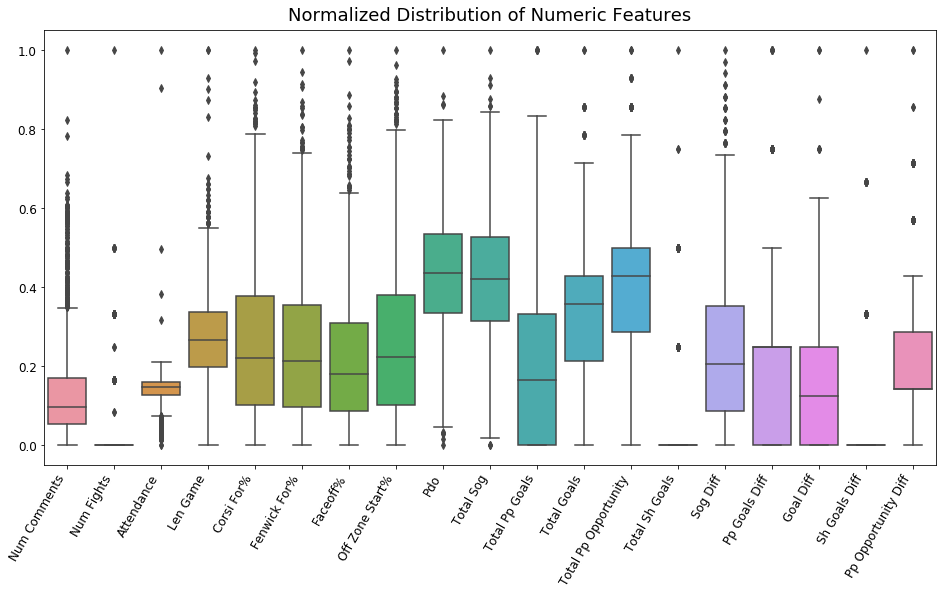

In [63]:
# Experiment with kind ('boxplot', 'violinplot', 'stripplot')

data_viz.plot_numeric_features_dist(data=total_data[continuous_game_data - ], kind='boxplot', size=(16, 8))

__Data Distributions:__
* Skewed:
    * Right Skewed:
        * Num Comments
        * Len Game
        * Corsi For %*
        * Fenwik For %*
        * Faceoff %*
        * Off Zone Start %*
        * Total Goals
        * Total PP Oppurtunity
        * Sog Diff
    * Left Skewed:
        * Attendance
            * Large outliers are outdoor games in football arenas (larger venues)
* Symmetric:
    * PDO
    * Total SOG

* Rare Events/Low Range:
    * Num Fights
    * Total PP Goals/PP Goals Diff
    * Total SH Goals/SH Goals Diff
    * Goal Diff
    * PP Oppurtunity Diff
    
*Percentages are 'absolute' (range from 50% - 100%) as the absolute deviation from 50% is the relevance of the statistic and direction is not important. Raw percentages have a distribuiton similar to PDO
    

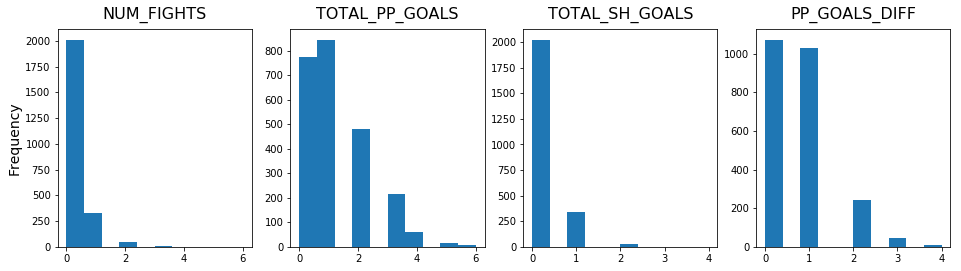

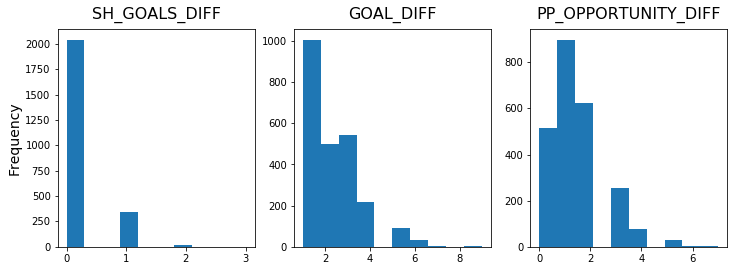

In [83]:
data_viz.plot_game_binary_data(total_data[['num_fights', 'total_pp_goals', 'total_sh_goals', 'pp_goals_diff']], size=(16, 4))

data_viz.plot_game_binary_data(total_data[['sh_goals_diff', 'goal_diff', 'pp_opportunity_diff']], size=(12, 4))

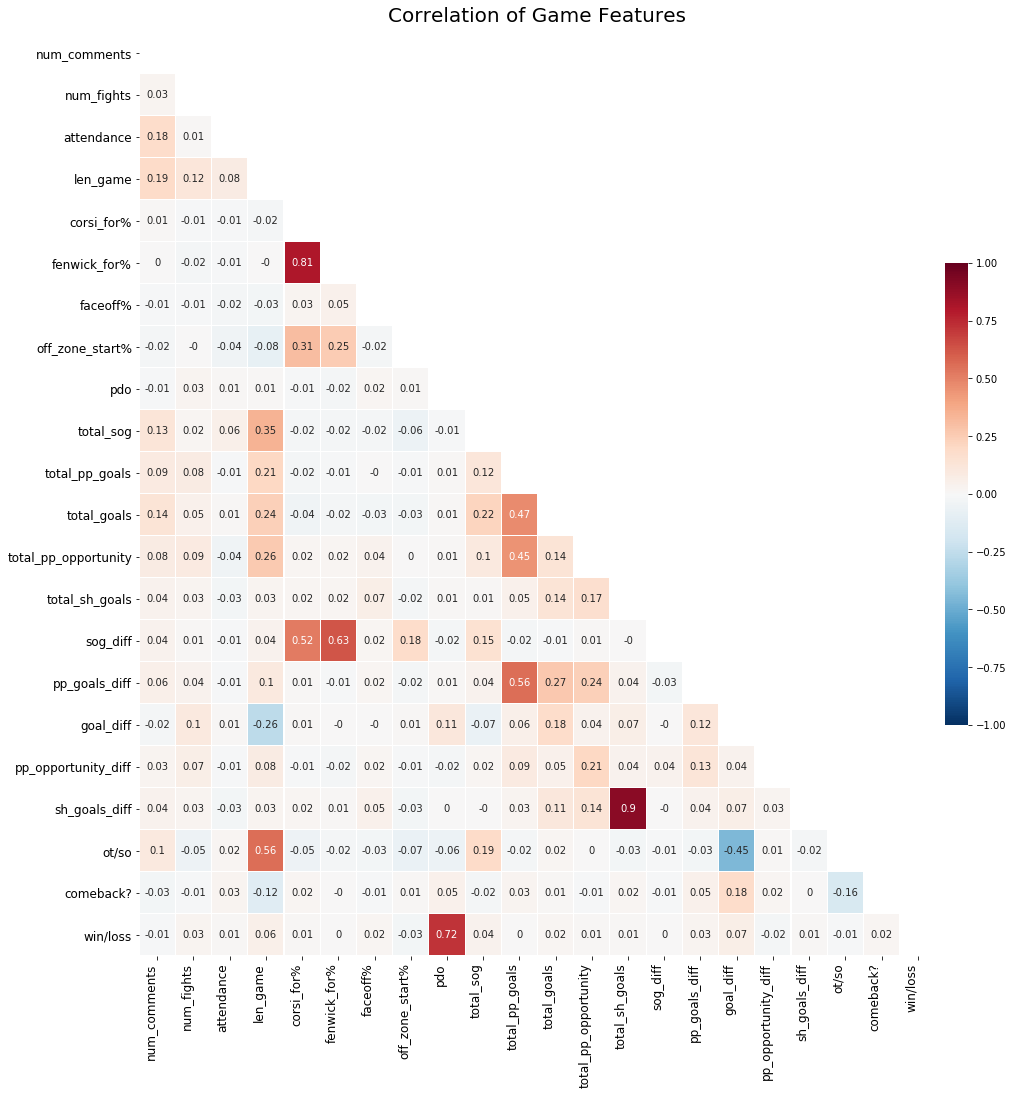

In [88]:
data_viz.plot_game_feature_heatmap(total_data)

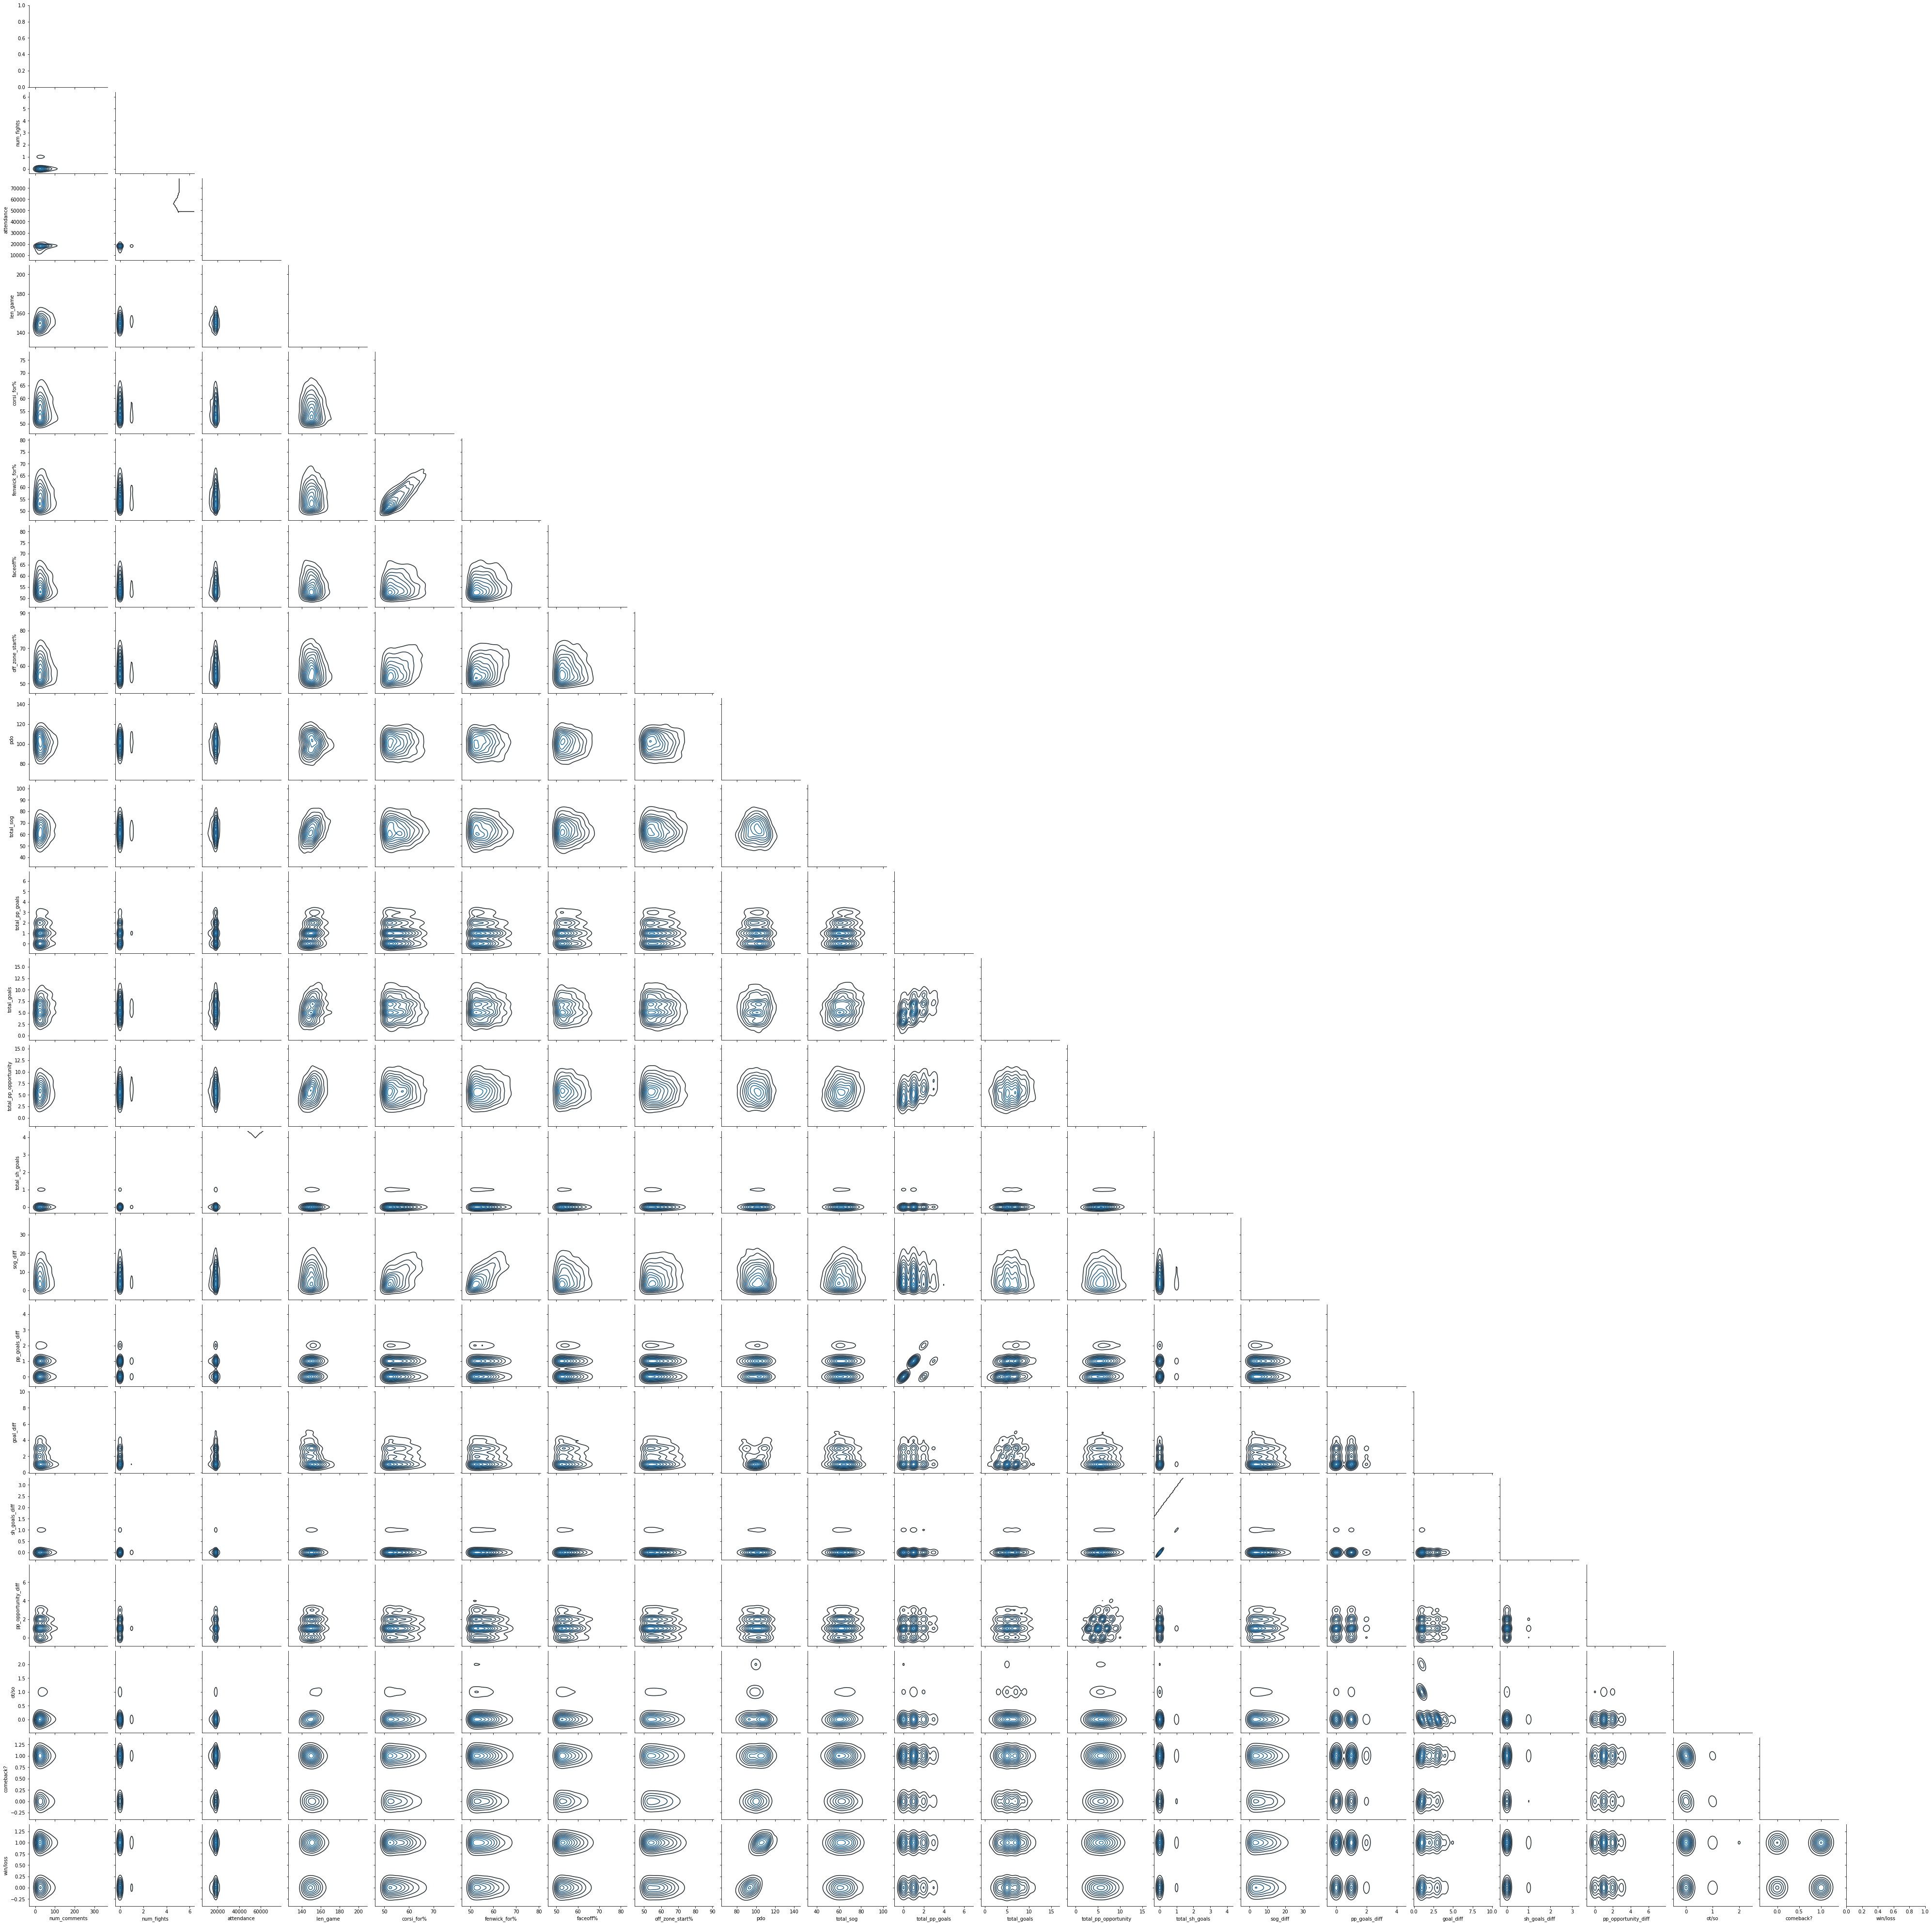

In [11]:
g = sns.PairGrid(total_data, vars=game_data, corner=True)
g = g.map_lower(sns.kdeplot)

__Observations:__
1. Cumulative statistics are correlated with eachother (number of fights, length of game, total SOG, total PP goals, total goals, total pp opportunity, ot/so). This is expected as all are expected to increase with the length of the game.
    * Note: Not observed for total SH goals due to rarity of SH goals
2. Number of comments is correlated with attendance. This may be a market effect as certain teams, specifically Toronto, consistently has high game attendance and number of comments.
3. Length of the game is negatively correlated with goal differential and comebacks. Larger goal differentials lower the possibility of overtime, hence the negative correlation is well explained. Negative correlation with combacks is interesting- this suggests that comebacks are more likely to occur within regular time.
4. Advanced metrics (corsi, fenwick) are correlated with eachother along with SOG differential. This is expected due to the definitions of corsi and fenwick.
5. PDO shows signficant corellation with whether a team wins or loses. This is expected as the statistic is linked to offensive/defensive ability to score/prevent goals. 
6. Offensive Zone Start % is correlated with SOG differential (and hence with corsi and fenwick). The more often one team is starting in the offensive zone, the bigger difference in shots on goals. This is an intuitive relationship as one must be in the offensive zone to obtain a shot at the goal (in vast majority of cases).
7. Total amount of SOG is correlated with SOG differential.
8. Powerplay and shorthanded statistics are correlated with eachother. This is expected as being shorthanded and being on a powerplay are simultaneous events during a game. 
9. Goal differential is correlated with a comeback. This is interesting as it shows that comebacks are usually won in multi-goal games (shown also with the correlation between comebacks and length of game). This is not an intuitive thought as a comeback was expected to be an indication of a closer, more competitive game.
10. Goal differential is also correlated with the number of fights, showing fights more likely in games that are not as close. 
11. Goal differential is negatively correlated with ot/so. This is intuitive as ot/so must be one-goal games by definition. 


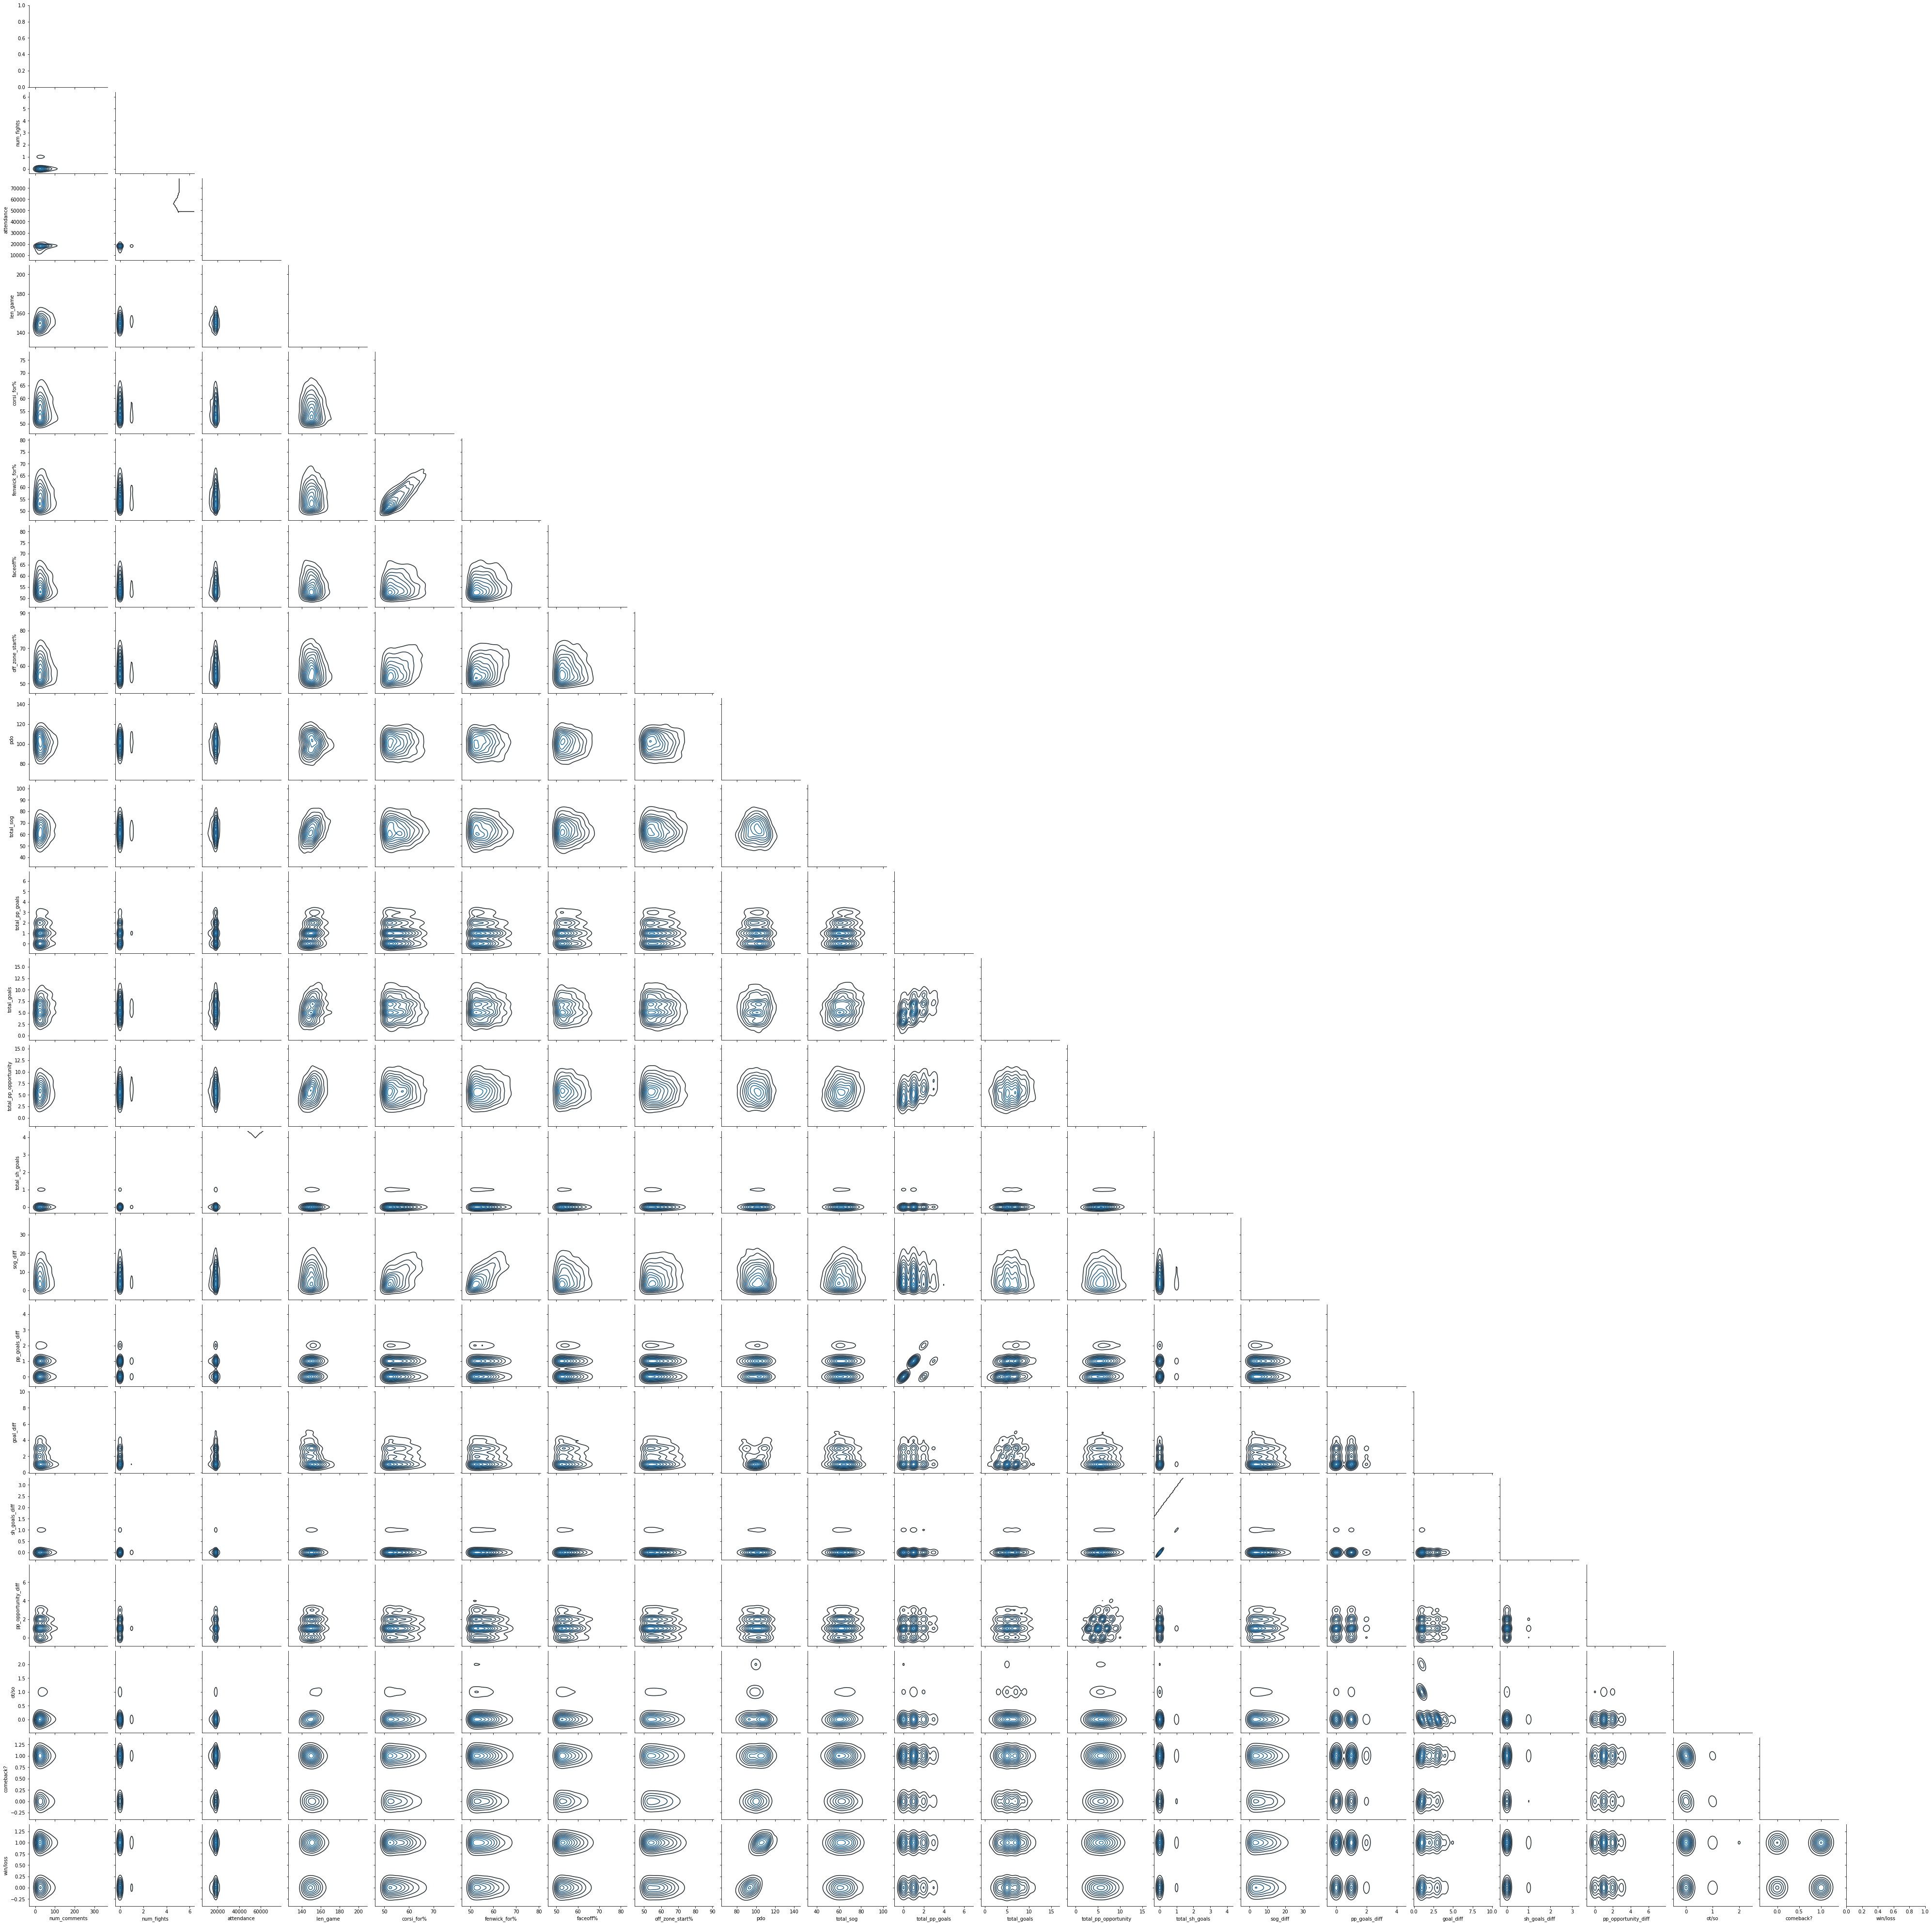

In [11]:
g = sns.PairGrid(total_data, vars=game_data, corner=True)
g = g.map_lower(sns.kdeplot)

### Team-Specific Data EDA
* Team-specific statistics are investigated for team-dependence on features. Highlights are shown here.

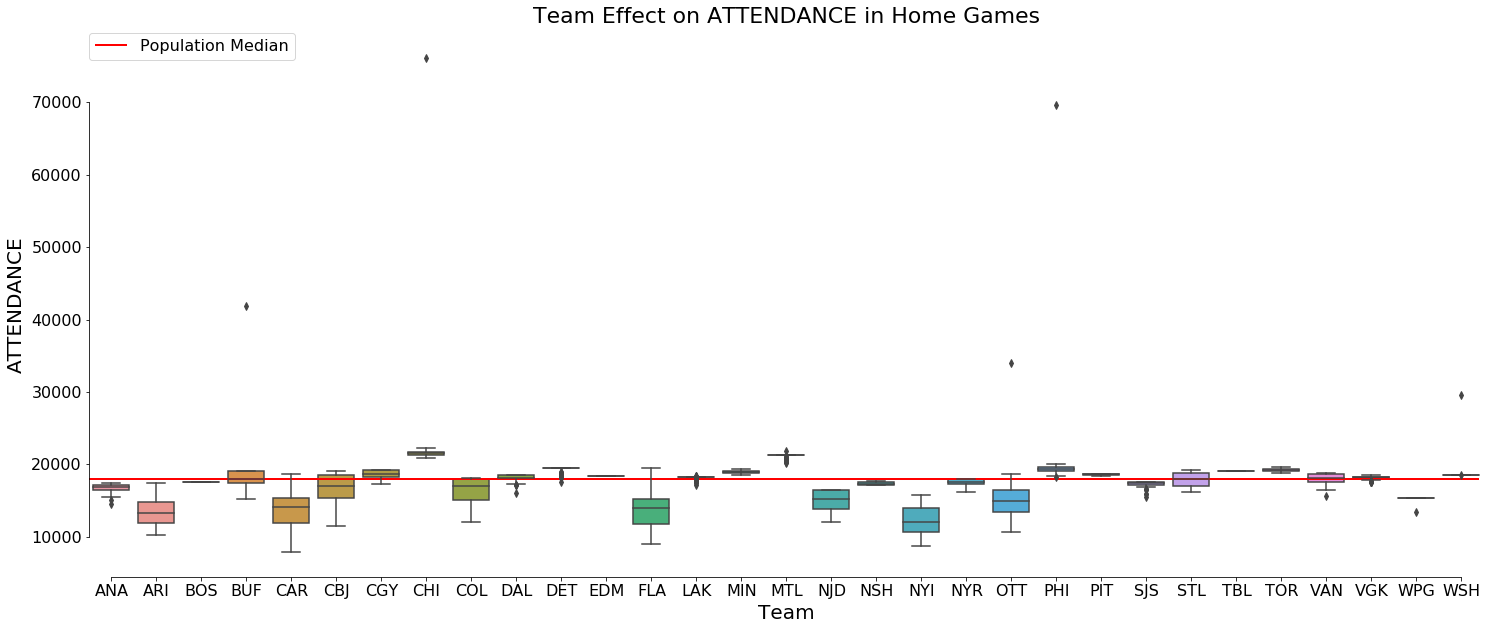

In [12]:
data_viz.plot_team_effect(total_data, statistic='attendance', kind='boxplot', game_venue='home')

_Markets that consitently get high/low game attendance during home games. This could be a proxy for market size, however venue size could play a role (% occupied may be a better metric)._
   
__Consistent high-attendance markets:__
* Toronto
* Montreal
* Minnesota
* Detroit
* Philadelphia
* Tamba Bay
* Pittsburgh

__Low-attendance markets:__
* Winnipeg
* Ottawa
* New York (Islanders)
* New Jersey
* Florida Panthers
* Colorado
* Columbus
* Carolina
* Arizona

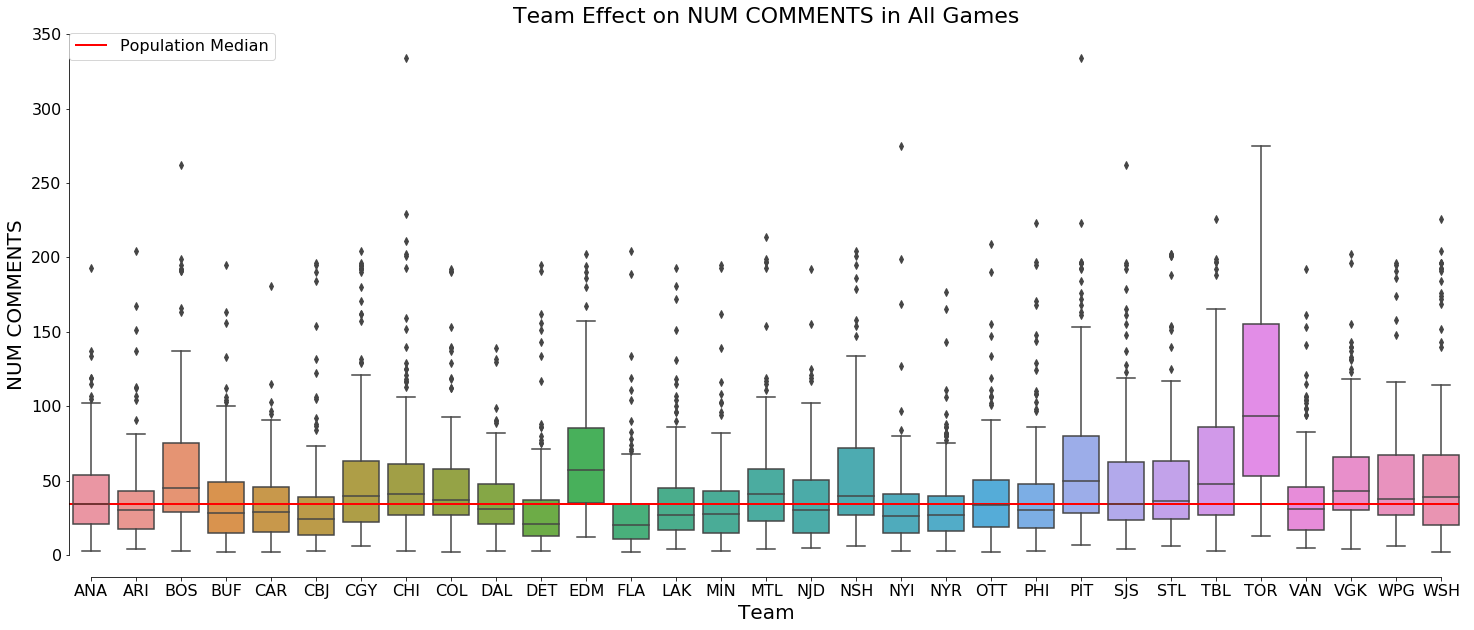

In [13]:
data_viz.plot_team_effect(total_data, statistic='num_comments', kind='boxplot', game_venue='all')

Fanbases are shown to have a different level of activity in the subreddit. Notably, the __active fanbases__ are:
* Boston
* Edmonton
* Pittsburgh
* Tamba Bay
* Toronto

__Less active fanbases:__
* Columbus
* Carolina
* Florida Panthers
* Detroit

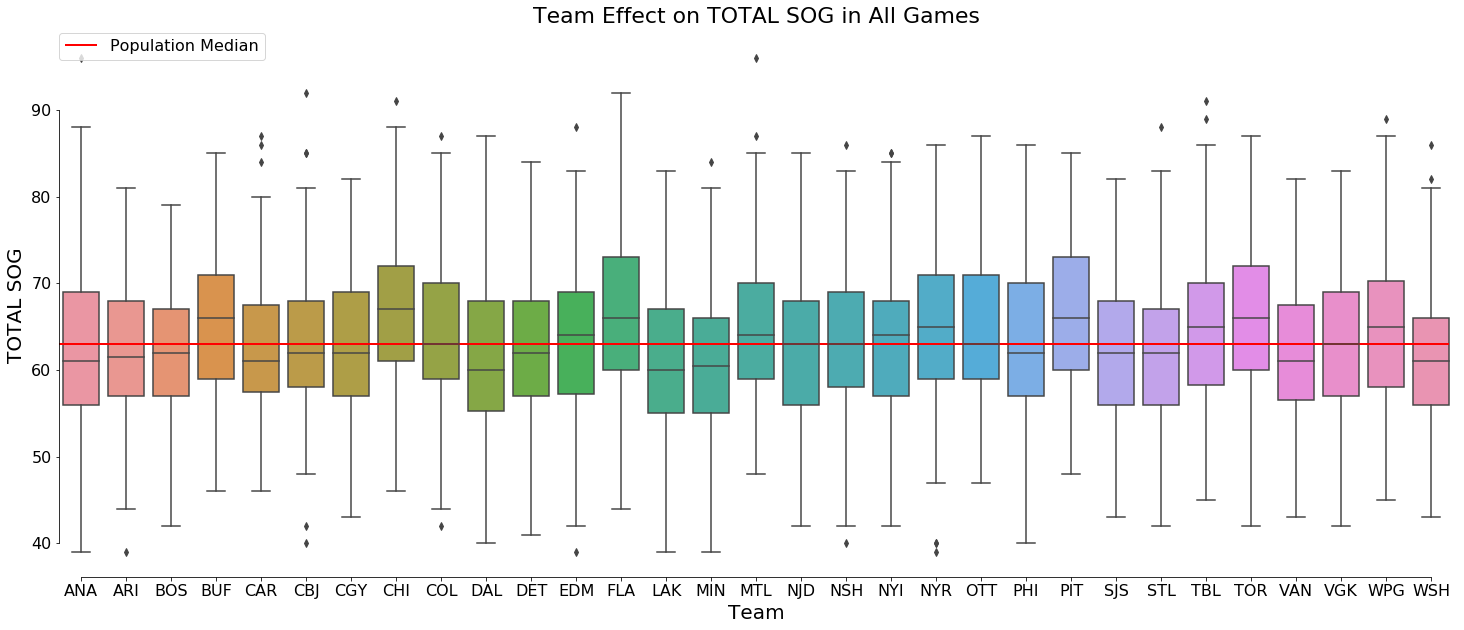

In [14]:
data_viz.plot_team_effect(total_data, statistic='total_sog', kind='boxplot', game_venue='all')

_Some game statistics are also team-dependent. For instance, Chicago, Pittsburgh, Buffalo, and Toronto tend to play in games with more shots on goal. Team-dependent effects like these could be used in modeling if the game statistic is corellated with game quality._

# NLP

## Individual Comment Analysis (Determine Best Method of NLP)

Several NLP sentiment scoring techniques were implemented on individual comments and analyzed based on efficacy. The goal of sentiment scoring is to show sentiment of game quality

Two main tools were used in score calculation:
* VADER -> a general social media sentiment analyzer


* SocialSent -> an algorithm developed at Stanford to automatically generate lexicon-specific sentiment scores. The researchers trained a model based on reddit/r/hockey to generate a dictionary with sentiment scores for the most frequent 5,000 words 

In [16]:
comment_data = pd.read_pickle('./data/comment_nlp_data')

In [17]:
comment_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101956 entries, 0 to 112443
Data columns (total 14 columns):
clean_comments                               101956 non-null object
vader_comments                               101956 non-null object
flair                                        101956 non-null object
fan                                          101956 non-null int64
word_socialsent_polarity                     101956 non-null object
vader_comment_polarity                       101956 non-null float64
full_socialsent_polarity                     101956 non-null float64
clean_context                                101956 non-null object
vader_context                                101956 non-null object
subreddit_context_word_socialset_polarity    101956 non-null object
subreddit_context_polarity                   101956 non-null float64
vader_context_polarity                       101956 non-null float64
context_socialsent_pos_polarity              101956 non-null float64
c

In [18]:
comment_data['fan'].mean()

0.6663953077798266

_2/3 of all comments are fans posting in threads of games in which their favorite team played_

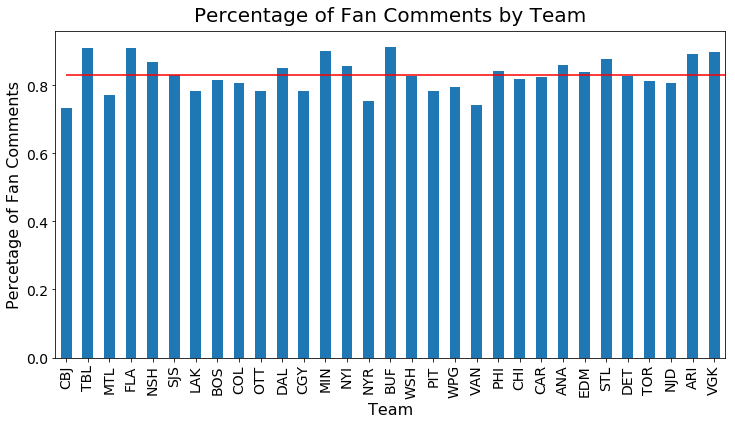

In [19]:
data_viz.plot_team_effect_comment_fandom(comment_data)

_Certain fanbases (e.g. Colombus, New York (Ranger), Vancouver, and Montreal)are more apt to comment in threads that there team didn't play in_

### VADER Scoring

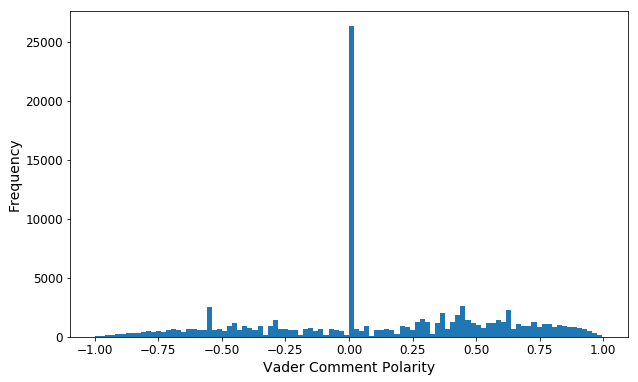

Percentage of neutral comments: 0.257


In [20]:
data_viz.plot_scoring_dist(comment_data, scoring='vader_comment_polarity')

In [96]:
get_sample_comment(comment_data, scoring='vader_comment_polarity', negative=False, perc=0.1, num_comments=3)

["most coaches seem to react the same way to losing lean more heavily on vets commit to defense at the expense of offense shut down creativity and go for safer plays it almost always backfires from everything bednar's said this year it seems he's learned from that and is more willing to give the keys to the youngsters helping build up their confidence   another huge difference is the makeup of the defense every pairing has a decent to fantastic puck mover on it and barrie finally has a stable partner who can support him without being an anchor that does so much for the team's breakouts and offensive creativity last year bednar had a stable of defensive anchors who were all possession black holes so he couldn't coach the defense to do much more than make the safe plays this year the balance between offense and defense is there so he can give a guy like barrie the freedom to do his thing and it seems to be paying huge dividends already"
 "flower  i love that man so much and i'm glad we c

In [95]:
get_sample_comment(comment_data, scoring='vader_comment_polarity', perc=0.1, negative=True, num_comments=3)

['i thought not   if you are the loud mouth cunt that sits in the last row of section 105 shut the fuck up you never shut your god damn drunk whore mouth from puck drop to the final horn you’re running your mouth at the loudest fucking volume you have no idea how much i despise you and the random group of trash you bring with you each game your talking is so exhausting and nauseating i have to take breaks during the middle of the period just to get a break you make the most enjoyable parts of the game the intermission when you and your filth go suck down as many cancer sticks as your lungs can handle you are ruining my season tickets fuck you every fucking game you are at'
 "skjei lifted krejci's stick into his own face that is a bullshit penalty no matter what if you lift a stick into your own face you played a stupid game you won a stupid prize   if that dumb penalty isn't called that goal doesn't happen of course the rest of the game might go differently but that was a momentum kill

_First analysis is done by sampling comments from the highest and lowest 0.1% (most extreme) of sentiment  scores_

_Sampled comments appear to be quite long and are less about game-quality, Comment length is expected to be correlated with VADER scores due to the nature of VADER scoring_

### SocialSent Scoring

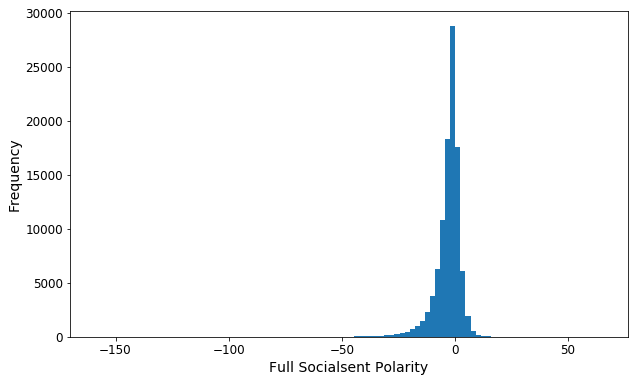

Percentage of neutral comments: 0.031


In [23]:
data_viz.plot_scoring_dist(comment_data, scoring='full_socialsent_polarity')

In [97]:
get_sample_comment(comment_data, scoring='full_socialsent_polarity', negative=False, perc=0.1, num_comments=3)

["1st star  ben bishop  2nd star  ben bishop's glove  3rd star  ben bishop's pads"
 "wow what a game that scheifle goal was highlight worthy av's are very good landesgogs goal was a sweet tip"
 'three stars of the game  1 rdallasstars 47 alexander radulov with the late goal to send it to ot 1 rdallasstars 30 ben bishop with 35 saves on 37 shots for a 946 sv please be okay ben 1 rstlouisblues 17 jaden schwartz with a goal    that was a great game jamie was something to watch tonight heh gg blues']


In [98]:
get_sample_comment(comment_data, scoring='full_socialsent_polarity', negative=True, perc=0.1, num_comments=3)

["are we more than you bargained for yet     we’ve been dying to crush you anyway you want perry     cause you're just who we'll beat this week     lie on the ice next to the goalie crease     we're just a notch in your losses      and you're just a win in a streak     a notch in your losses     and you're just a win in a streak            drop the puck break a stick     we’re always cheering loud cheering for the gold team        you’re going down down in an earlier round     and kesler you’re going down weeping     we’ll beat your number one with johansen      you ugly god complex cocky and dirty        you’re going down down in an earlier round     and kesler you're going down weeping      we’ll beat your number one with johansen      you ugly god complex cocky and dirty        is this more than you bargained for yet     oh don't mind us we're sweeping your team in the season     wishing to be the reason you miss seeds     isn’t it messed up how you're just dying to beat us     we'r

_Like with VADER scoring, comments are quite long and not related much to the game-quality, Comment length is expected to be correlated with the cumilative nature of the scoring technique_

### Game Context (+/- 5 words surrounding 'game')

_Proceeding, scoring was done only on the context (defined here as the 5 words before and after) of the word 'game'. This is to prevent scoring comments that are not about the game quality._

_12.7% of comments mention the word 'game'_

In [99]:
len(comment_data.loc[comment_data.clean_context != ''])/len(comment_data)

0.12663305739730865

In [27]:
game_relevant_comments = comment_data.loc[comment_data.clean_context != '']

#### VADER Scoring

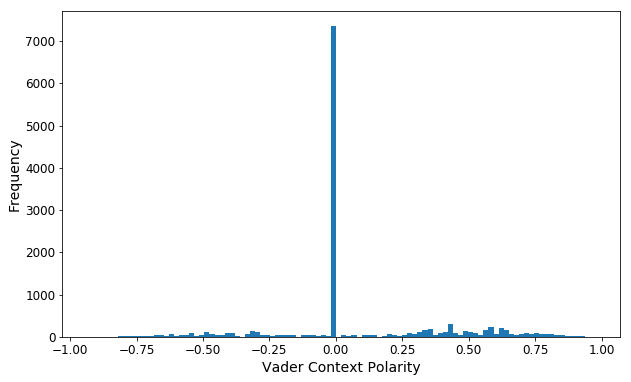

Percentage of neutral comments: 0.569


In [28]:
data_viz.plot_scoring_dist(game_relevant_comments, scoring='vader_context_polarity')

In [107]:
get_sample_comment(game_relevant_comments, scoring='vader_context_polarity', negative=False, perc=0.1, num_comments=3)

['fun game flyers great game if you like watching goalies duke it out mrazek and lindgren were awesome'
 'thanks for the great game caps best of luck in the postseason and may we meet in the cup final'
 'after a disappointing start about the first period and a half we came to life in an amazing comeback   still stressful to the end  wings played a great game overall considering where they are in the standings  they have some promising young talent  very exciting game overall  very civil gdt as well']


In [113]:
get_sample_comment(game_relevant_comments, scoring='vader_context_polarity', negative=True, perc=0.1, num_comments=3)

['terrible game for edmonton terrible game to lose after such a good streak and with the pacific doing very well  we have to bounce back immediately'
 'fuck this game frustrated the hell out of me would be great if chicago could show up to a game before its the final 5 minutes'
 'unfortunately the loud minority makes you all look bad  it was a hell of game for sure shame we don’t play more often']


_These comments are more centered around game quality and the positive comments contain phrases such as 'great game' while negative comments complain about either the game or team_

#### SocialSent Scoring

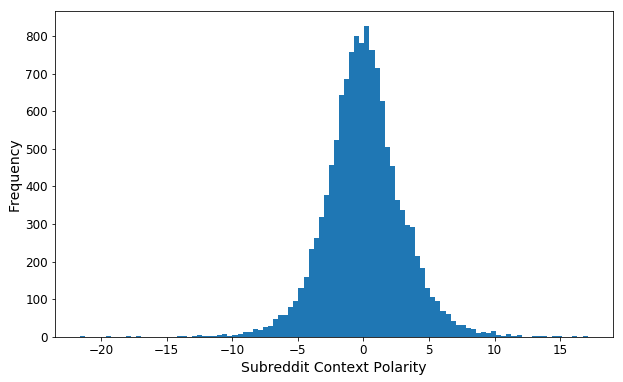

Percentage of neutral comments: 0.0


In [125]:
data_viz.plot_scoring_dist(game_relevant_comments, scoring='subreddit_context_polarity')

In [114]:
get_sample_comment(game_relevant_comments, scoring='subreddit_context_polarity', negative=False, perc=1, num_comments=3)

['great game  but god damn it'
 'hurricanes are 52 since i got a canes fidget spinner for christmas which i spin on game days for good luck '
 'exciting game good game looking forward to the next time']


In [115]:
get_sample_comment(game_relevant_comments, scoring='subreddit_context_polarity', negative=True, num_comments=3)

["i really don't understand it i was thinking about this during the 2016 playoffs i just keep imagining casual fans tuning in the first period is fast and there are a couple goals then you get to the intermission and fucking milbury and roenick come on the tv to tell you how shitty the game is the best players actually suck and the refs are actively handing the game to one of the teams   i understand the idea that controversial opinions make for more lively discussion but are the intermissions of your featured games the time for that that has to turn off potential fans "
 'great game ruined by garbage reffing once again good game boys'
 "the first penalty of the game was a soft call and then they get a 5 on 3 and can't score the refs also didn't call a blatant tripping on comeau in the third but the refs lost them the game"]


_Similar results are seen with SocialSent scoring, although some of the more negative comments are focused on the refereeing of the game_

##### Do not consider comments pertaining to refs (Social Sent Scoring)

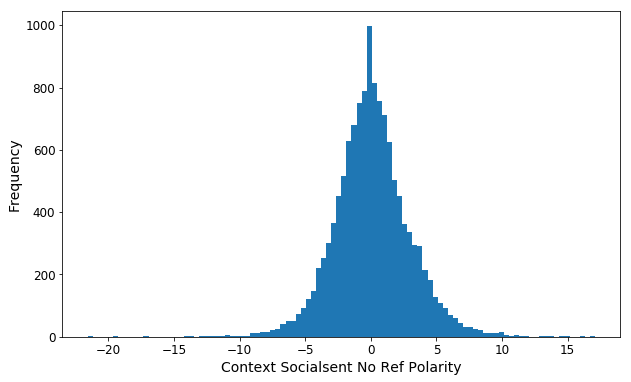

Percentage of neutral comments: 0.017


In [41]:
data_viz.plot_scoring_dist(game_relevant_comments, scoring='context_socialsent_no_ref_polarity')

In [116]:
get_sample_comment(game_relevant_comments, scoring='context_socialsent_no_ref_polarity', negative=False, perc=1, num_comments=3)

['such a damn good game gg '
 'i really wish getzlaf finished that absolutely filthy dangle  holy fuck that was a fun game and a fun gdt '
 'shoutout to all the guys from the gdt  good thread good game fun hockey']


In [117]:
get_sample_comment(game_relevant_comments, scoring='context_socialsent_no_ref_polarity', negative=True, num_comments=3)

['this game made me feel bad for being happy i wish all the best to you sens fans may your owner sell soon'
 'this game just made me think we went from like 15 overall in the draft to 610 but also nets us alittle extra when we trade green at the deadline pump to see the kids kinda step up tho and then zetty being zetty i kinda hope and expect us to suck and draft a solid dman this year but this game gave me too much hope'
 'no you’re right my thing is just that if there were opportunities to call a penalty and we only got one pp the whole game why not even it up by making one of the calls that they easily could have made you see it happen all the time in the nhl it’s very common so it’s kind of a kick in the nuts that it didn’t happen   especially when they decide to finally give us a call with 13 seconds left that’s just mean virtanen got hooked in the hands on a rush twice in the last 8 minutes of the game just feels shitty to lose when we weren’t quite given a fair shake you know']


_To avoid complaints about the refereeing quality (not game quality), if the word 'ref' was contained in the comment, the comment was not considered. However, other related words such as penalty remained and the most negative comments tend to be discussing the same topic_

##### Only Consider Positive Polarity Scores (SocialSent Scoring)

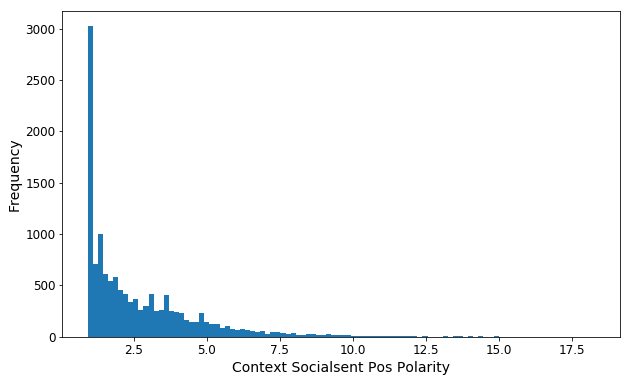

Percentage of neutral comments: 0.0


In [34]:
data_viz.plot_scoring_dist(game_relevant_comments, scoring='context_socialsent_pos_polarity')

In [35]:
get_sample_comment(game_relevant_comments, scoring='context_socialsent_pos_polarity', negative=False, perc=1, num_comments=3)

['tvr with the clutch save and game winner what a beauty'
 'the arena was unreal such a fun game to watch and good teams suck against us even without eichel '
 'gg penguins that was one exciting fucking game absolute killer game by kari klingberg continues to be great radulov continues seeing eye passes 5 game scoring streak for seguin 4 points out of 4 on a hell of a back to back series 5 game winning streak 3 points from the captain   and we still cant make any fucking progress in the standings fuck the central']


In [36]:
get_sample_comment(game_relevant_comments, scoring='context_socialsent_pos_polarity', negative=True, num_comments=3)

['before during and after the game '
 "i remember giordano going kneetoknee with koivu that one dude jumping dumba flames going after dumba and running him all next game and hathaway smashing kunin's face into the boards"
 'fantastic game no longer dread a playoff matchup with nashville from an entertainment perspective i feel like most games we have against the preds have been snoozers but that was fantastic']


_A different tactic to remove the influence of refereeing reviews is to only consider the words holding positive sentiment (as words like ref and penalty carry negative sentiment in the SocialSent /r/hockey dictionary)_

#### Only Consider Game Context From Non-Fan Comments (SocialSent Scoring)

_To reduce fan bias in comments, comments written by a fan of the teams playing are not considered in scoring (NOTE: 33% of comments and 4.2% of comments containing 'game' are from non-fans)_

In [119]:
len(non_fan_relevant_comments)/len(comment_data)

0.042076974381105574

In [37]:
non_fan_relevant_comments = game_relevant_comments.loc[game_relevant_comments['fan'] == 0]

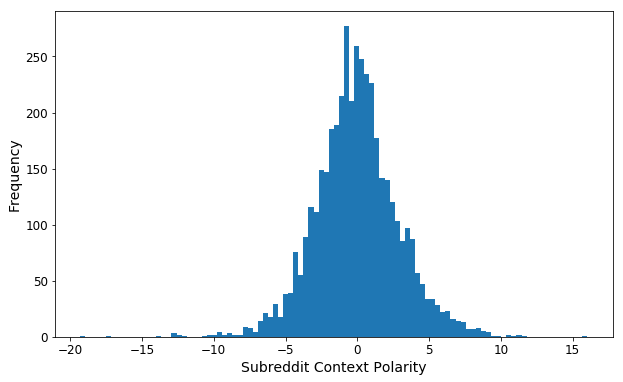

Percentage of neutral comments: 0.0


In [38]:
data_viz.plot_scoring_dist(non_fan_relevant_comments, scoring='subreddit_context_polarity')

In [122]:
get_sample_comment(non_fan_relevant_comments, scoring='subreddit_context_polarity', negative=False, perc=1, num_comments=3)

['what a game great game from letang 3200 toi in a regular season game holy smokes '
 'real fun game to watch puck the fens'
 "donskoi's move was absolutely incredible miller was great this game so props to him too "]


In [123]:
get_sample_comment(non_fan_relevant_comments, scoring='subreddit_context_polarity', negative=True, num_comments=3)

['lol what my original comment which you replied to said that philly fans were claiming it was the refs fault on the game thread as well as on the teams post game threads i’m just giving you evidence of what you asked for when you said “what who is saying they lost because of the refs” i just gave you 4 examples and i’m sure there are a lot more '
 "refs didn't have a clue either way that game some shitty calls and a whole bunch of non calls terrible refs  really good game by the teams though"
 'we get heavily outshot every single game we have either the worst or second worst high danger chance percentage in the entire league our 4th line and 3rd defensive pairing would barely be replacement level in the ahl   this team needs change and i have exactly 0 hope in trotz being the guy to bring it or gmbm being able to grow a pair big enough to fix things']


_Shows a similar result as taking comments from any fanbase. Complaining about refereeing in the negative comments is common_

## Game Thread Analysis

_Relationships between the aggregated sentiment scores of game thread comments and game statistics are investigated_

In [44]:
thread_data = pd.read_pickle('./data/thread_data_nlp')

In [45]:
nlp_data = ['fan%', 'vader_comment',
       'socialsent_comment', 'vader_context',
       'socialsent_context', 'positive_context', 'non-fan_context',
       'no_ref_context']

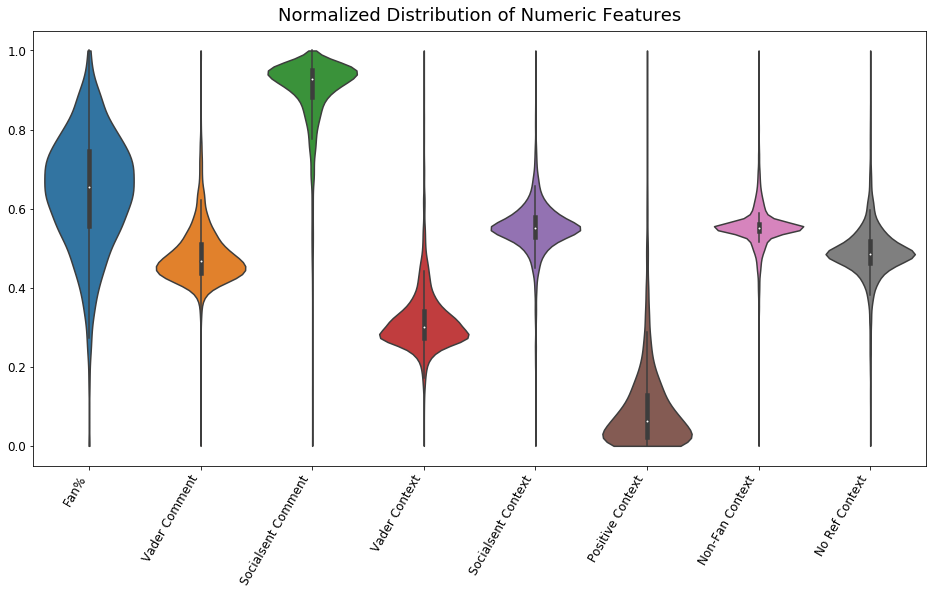

In [46]:
data_viz.plot_numeric_features_dist(thread_data[nlp_data], kind='violinplot', size=(16, 8))

_Distributions of most scores (VADER full comment scores, VADER context scores, SocialSent context scores, Non-fan context scores, and non-ref containing context scores) are symmetric and heavily tailed._

_Scores that don't follow this trend are positive context, which is right skewed (in the positive direction, as expected) and SocialSent full comment scores, showing that more lexicon-specific negative words are used in these threads._

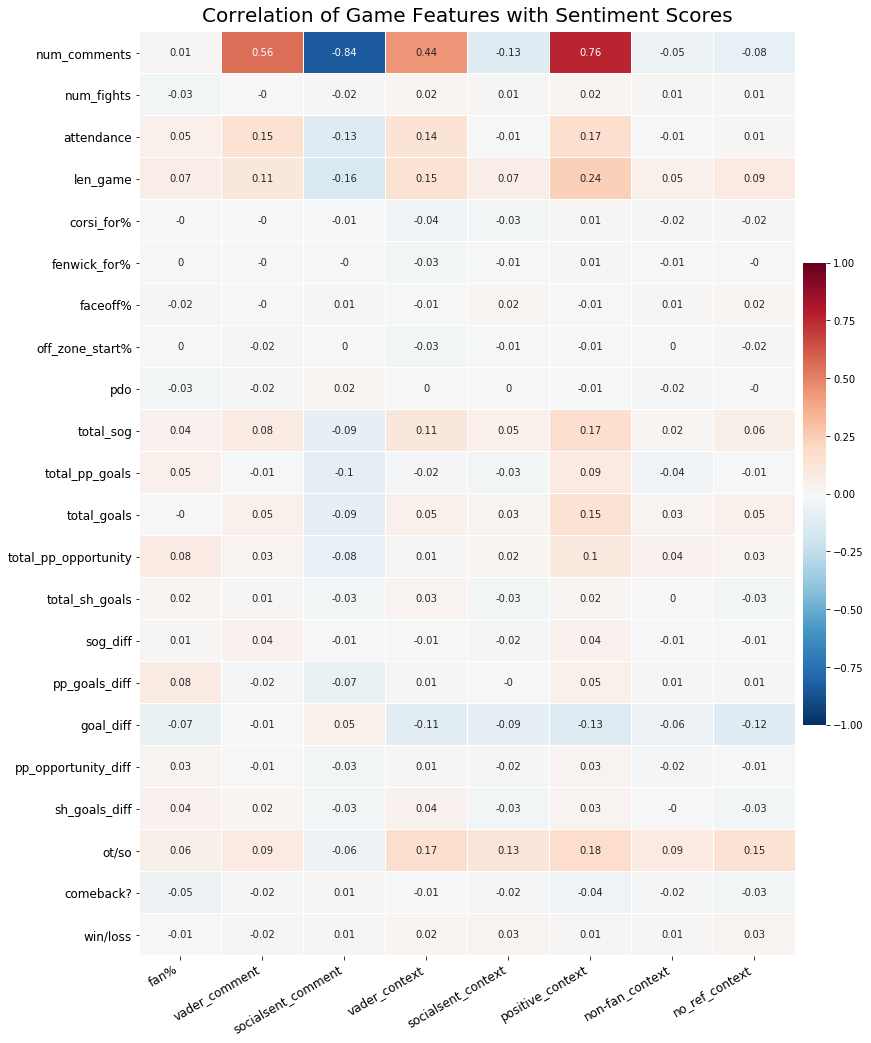

In [47]:
data_viz.plot_nlp_heatmap(thread_data)

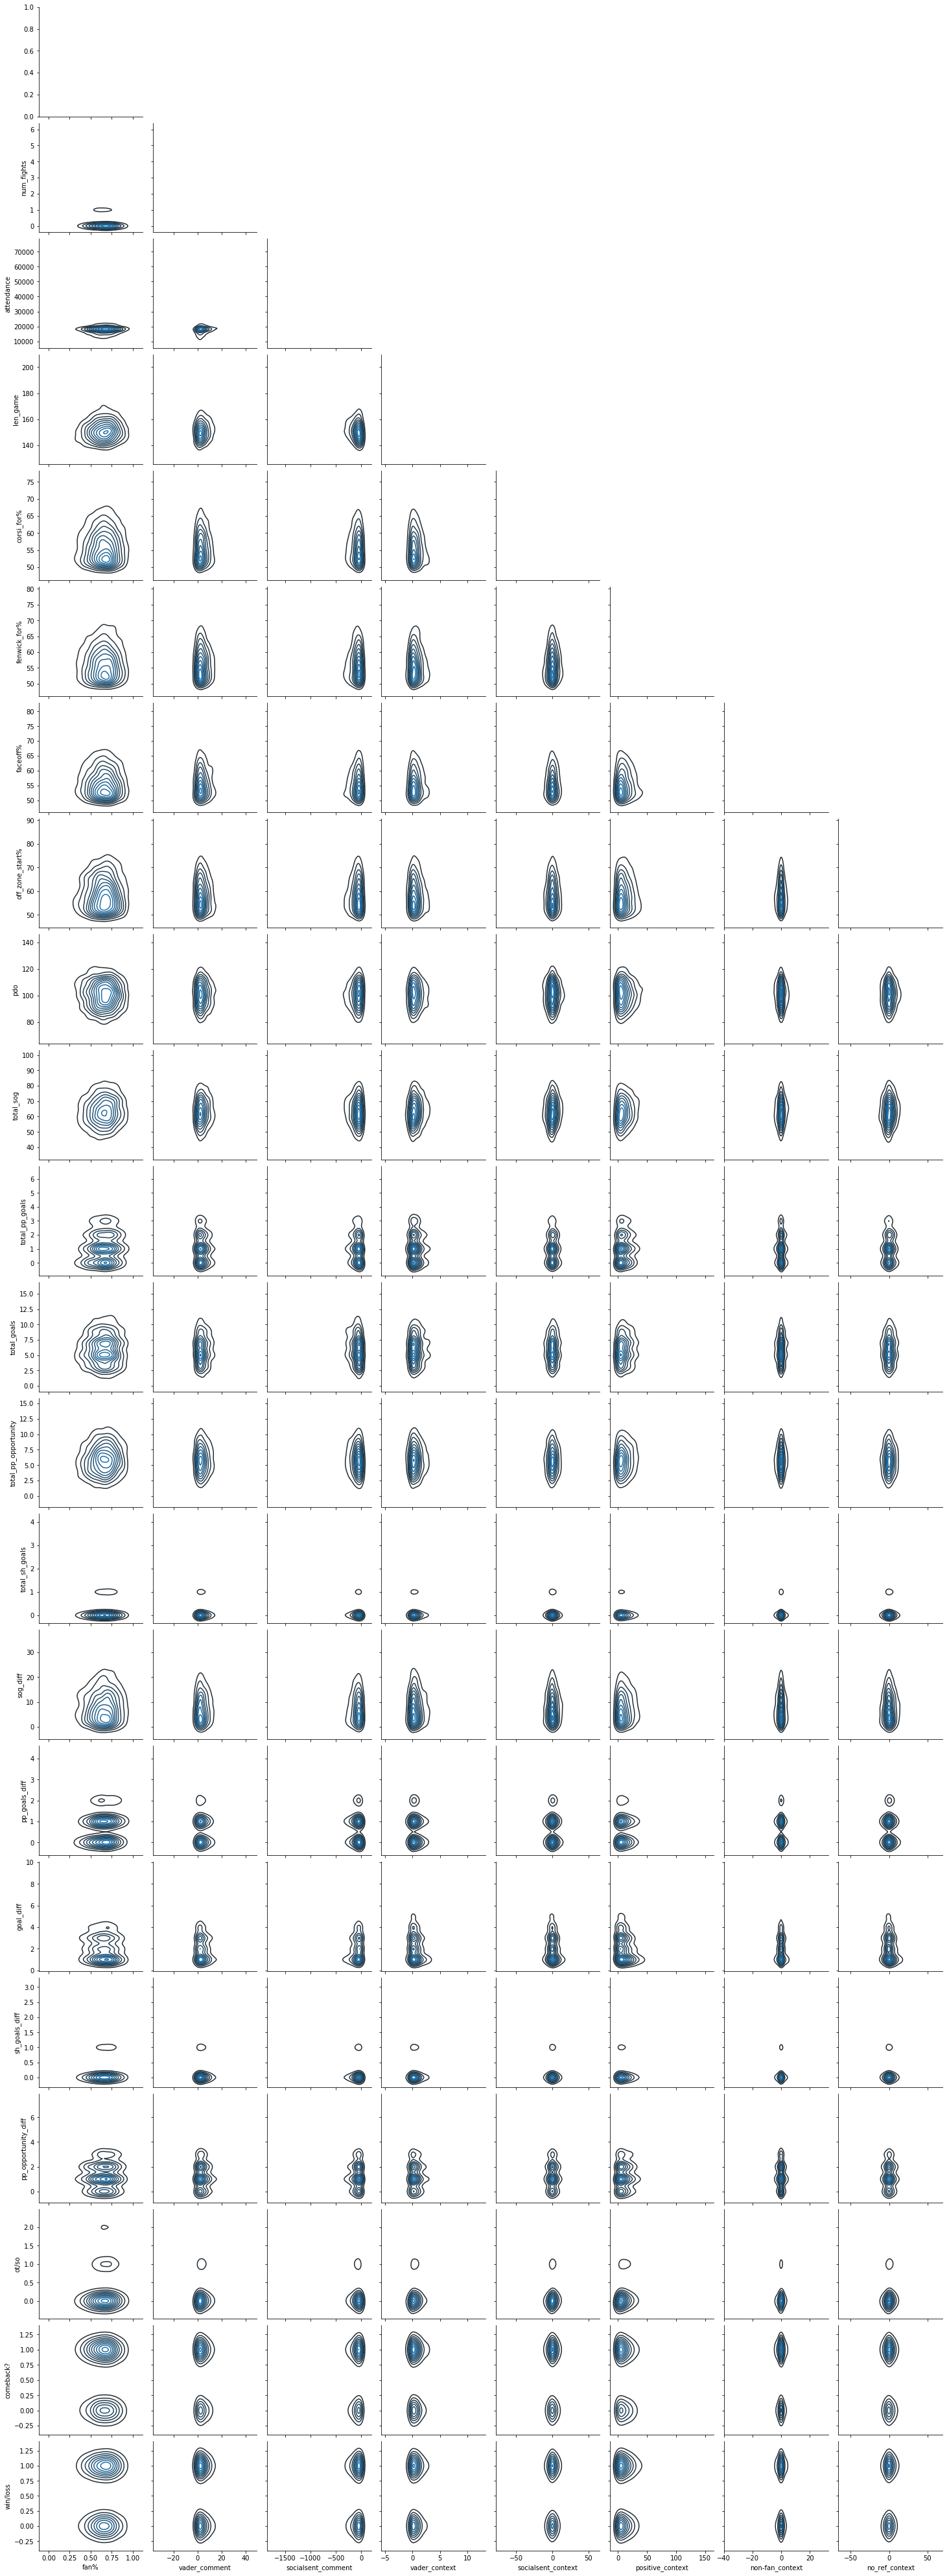

In [48]:
g = sns.PairGrid(thread_data, x_vars=nlp_data, y_vars=game_data, corner=True)
g = g.map_lower(sns.kdeplot)

_Strong correlation with game statistics are generally absent. However, some observations are of note:_
* Correlated statistics (ot/so, attendance, game length, aggregated game even statistics) all show some correlation with scoring
* Number of comments shows strong correlation with VADER scoring as well as SocialSent Scoring (although only of the the entire comment or consideration of positive words only)
* Among scoring techniques, SocialSent scoring (only considering positive words) showed the most correlation with game statistics
* Game stats show similar trends in their correlation with game statistics:
    * Negative Corellation:
        * Goal differential (closer games have more positive sentiment scores)
    * Positive Corellation:
        * OT/SO
        * Total Goals
        * Total Shots
        * Len Game
        * Attendance
* Trends in correlation suggests that games that are closer with high scoring/shooting are generally more enjoyed

# Future Work

1. Investigate regression of sentiment scores with recent team performance. _Can sentiment scores be predicted?_


2.  Investigate clustering techniques to label similar games according to game statistics. Build a classification or reccomendation model.


3. Reddit is only a segment of NHL fanbase, expand to other social media and forums